# Statistical and numerical methods in cosmology
# HW #6
### *Hernán E. Noriega B.*
### Instituto de Física, Universidad Nacional Autónoma de México

In [1]:
import numpy as np
import scipy
import math
import statistics
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Redshift Space Distortions - RSD 

In [2]:
#1. Read the file, get positions and vel. of galaxies - select the central galaxies

#Flag: type of galaxy, 0 if central, 1 if satellite
Data = np.loadtxt('Data_galaxies_z0695.txt')
Data_c = np.delete(Data, np.where( Data[:,6] == 1 ), 0) #only central galaxies
Data_c = np.swapaxes(Data_c,0,1) #reshape
X = Data_c[0] 
Y = Data_c[1]
Z = Data_c[2]

#Velocities [Km/s]
V_X = Data_c[3]
V_Y = Data_c[4]
V_Z = Data_c[5]

Cosmology: $\Omega_{m} = 0.3, \quad \Omega_{\Lambda} = 0.7 $

$$H(z) = H_{0} \sqrt { { \Omega  }_{ m,0 }{ \left( 1+z \right)  }^{ 3 }+{ \Omega  }_{ \Lambda ,0 } }  $$

here $z = 0.695$

In [3]:
#We set the cosmology
Om = 0.3  #Om: Omega matter
Ol = 0.7  #Ol: Omega Lambda
H0 = 70   #Hubble const. [(Km/s)/Mpc]
z = 0.695 #given at HW#6

#H(z): Hubble parameter as function of z
def H(z): 
    return H0 * math.sqrt(Om*(1+z)**3+Ol)
H_z = H(z) 

Remember,

$$ s=r+\frac { \hat { r } \cdot \vec { v }  }{ H(z) } (1+z) $$

here, $\hat { r } = \hat {Z}$  (line of sight is along the $Z$-axis)

Warning: capital letters $X,Y,Z$ refers to positions, and the lower case $z$ refers to redshift. 

In [4]:
#2. Generate new positions applying the RSD according to the Z-axis

#S_i, where i = X,Y,Z : Positions in redshift space 
S_X = X  
S_Y = Y  
S_Z = Z + V_Z * (1+z)/H_z

In [5]:
#We organized the new positions in S_Z (due to RSD these can be outside the box)

l = round(np.amax(X))

for ii in range(len(S_Z)):
    S_Z[ii] = S_Z[ii] 
    #periodicity
    if (S_Z[ii] < 0):
        S_Z[ii]  = S_Z[ii]  + l
    if (S_Z[ii]  > l):
        S_Z[ii]  = S_Z[ii]  - l

In [6]:
#3. Generate the cube of galaxy density

grid_size = 5 #given by HW#6
m = int(l/grid_size) #"subintervals"
den_arr = np.zeros((m, m, m)) # density arr: Original positions (200x200x200)
denRSD_arr = np.zeros((m, m, m)) # denRSD_arr: positions after applying RSD

#original positions: real space
for ii in range(len(X)):
    i = int(np.floor(X[ii])/grid_size) 
    j = int(np.floor(Y[ii])/grid_size)
    k = int(np.floor(Z[ii])/grid_size)  
    den_arr[i][j][k] = den_arr[i][j][k]+1

den_arr = den_arr/grid_size**3 #number density

#New positions: redshift space 
for ii in range(len(S_X)):
    i = int(np.floor(S_X[ii])/grid_size) 
    j = int(np.floor(S_Y[ii])/grid_size)
    k = int(np.floor(S_Z[ii])/grid_size)  
    denRSD_arr[i][j][k] = denRSD_arr[i][j][k]+1

denRSD_arr = denRSD_arr/grid_size**3 #number density

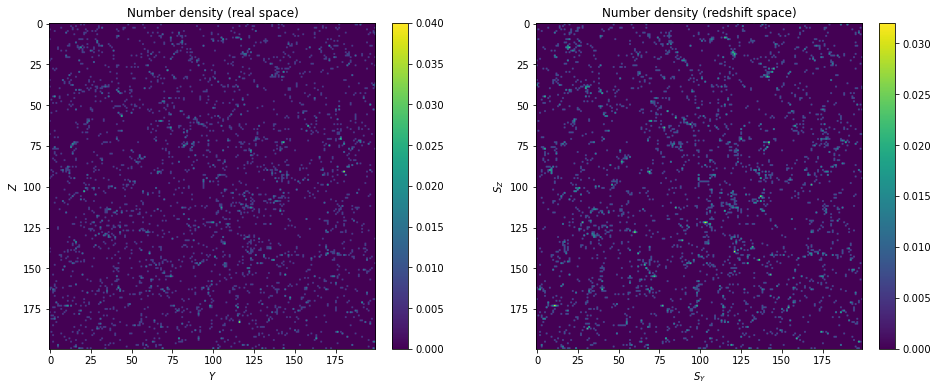

In [7]:
#4. Plot a slice at a given position in X-axis of the two density cube

fig, axs = plt.subplots(1,2,figsize=(16,6))

im1 = axs[0].imshow(den_arr[0,:,:]) #X=0
fig.colorbar(im1, fraction=0.046, pad=0.04, ax=axs[0])
axs[0].set_title(r'Number density (real space)')
axs[0].set_xlabel(r'$Y$')
axs[0].set_ylabel(r'$Z$')

im2 = axs[1].imshow(denRSD_arr[0,:,:]) #S_X=0
fig.colorbar(im2, fraction=0.046, pad=0.04, ax=axs[1])
axs[1].set_title(r'Number density (redshift space)')
axs[1].set_xlabel(r'$S_Y$')
axs[1].set_ylabel(r'$S_Z$')
plt.show()

Do you see a difference? Of course, they are different. You can observe that the peculiar velocities of galaxies cause them to appear displaced along the line of sight. These displacements lead to redshift distortions in the pattern of density in the redshift space.

Remember: 

1. the overdensity,

$$\delta (r)=\frac { \rho (r)-\bar { \rho  }  }{ \bar { \rho  }  } $$

2. The Nyquist frequency (max frequency without aliasing) $K_{Ny}$ and the $K_{min}$ are given by,  
 
 $$ K_{Ny}={\pi n}/{l} \quad \& \quad  K_{min} = 2\pi/l $$

 Here: $n=200$ and $l=1000$ 

In [8]:
#5. Calculate the Power Spectrum for the two cube of density

n = 200
step = int(l/n)

#overdensities : $\delta(r)$ for two cube density
delta_r = den_arr/np.mean(den_arr) - 1             #original
deltaRSD_r = denRSD_arr/np.mean(denRSD_arr) - 1    #with RSD (eq 3.18 - Hamilton)

#FT of $\delta(r)$ -> $\delta(k)$ 
delta_k = np.fft.fftshift(np.fft.fftn(delta_r))  #delta_k organized  (original)
deltaRSD_k = np.fft.fftshift(np.fft.fftn(deltaRSD_r)) #deltaRSD_k organized (with RSD)

k = np.fft.fftshift(np.fft.fftfreq(n, d = step)*2*np.pi) #freq. organized
kmin = k[n//2+1]  
kmax = np.amax(np.abs(k))
print("k_min:", kmin)
print("k_max:",kmax)

k_min: 0.006283185307179587
k_max: 0.6283185307179586


In [9]:
#we define the distance function as "D(kx,ky,kz)"
def D(kx,ky,kz):
    return math.sqrt(kx**2+ky**2+kz**2) 

#we define the variance method (Bessel's correction)
def var_method(lst): 
    n = len(lst)
    return sum((x) ** 2 for x in lst) / float(n - 1) 

In [10]:
stps = np.linspace(kmin,kmax,100) #steps + kmin = 0.006283(aprox)
k_mod = np.zeros((len(k),len(k),len(k))) #modulus/distances    

p_k = np.zeros(len(stps)) #power spectrum (original)
pRSD_k = np.zeros(len(stps)) #power spectrum (with RSD)

#we calculate de distances
for ii in range(len(k)):
    for jj in range(len(k)):
        for kk in range(len(k)):
            k_mod[ii,jj,kk] = D(k[ii],k[jj],k[kk])

#we classify the vector by intervals, np.where() return a tuple of indices
for jj in range(1,len(stps)):
    k_index = np.where( (k_mod < stps[jj]) & (k_mod >= stps[jj-1]) )
    k_x = k_index[0]
    k_y = k_index[1]
    k_z = k_index[2]
    p_k[jj] = var_method(np.abs(delta_k[k_x,k_y,k_z]))
    pRSD_k[jj] = var_method(np.abs(deltaRSD_k[k_x,k_y,k_z]))

#check N-point-stat.pdf
l = 1000
n = 200
norm_factor = l**3/n**6 #normalization factor (FFTW convention)
p_k = np.delete(p_k,0)*norm_factor 
pRSD_k = np.delete(pRSD_k,0)*norm_factor 

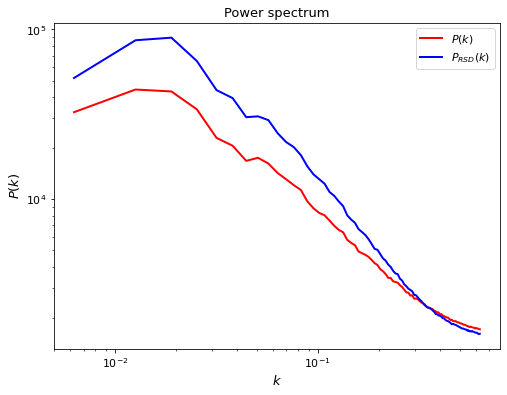

In [11]:
#6. Plot on the same figure the 2 Power Spectra you get (in log-log scale)

k_range = np.linspace(kmin,kmax,len(p_k)) 

plt.figure(figsize = (8,6))
plt.title(r'Power spectrum',fontsize=13)
plt.xlabel(r'$k$',fontsize=13)
plt.ylabel(r'$P(k)$',fontsize=13)

#log-log scale
plt.loglog(k_range,p_k,color='red',ls='-',lw=2,label=r'$P(k)$')
plt.loglog(k_range,pRSD_k,color='blue',ls='-',lw=2,label=r'$P_{RSD}(k)$')

plt.legend(fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

Remember,

$$\frac { { P }_{ RSD }(k) }{ P(k) } =1+\frac { 2 }{ 3 } \beta +\frac { 1 }{ 5 } { \beta ^2  }$$

where,

$\beta = f/b \quad f= 0.81, b = 2.1 $

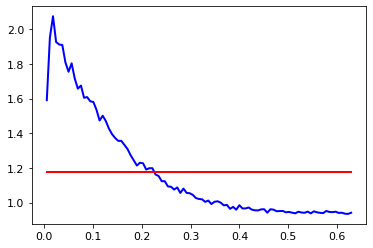

In [12]:
f = Om**0.55 #Peebles approx
b = 2.1 #bias
beta = f/b
    
p_diff = np.zeros((k_range.size)) 
for ii in range(k_range.size):
    p_diff[ii] = 1 + 2/3 * beta + 1/5 * beta**2
plt.plot(k_range,pRSD_k/p_k,color='blue',ls='-',lw=2)
plt.plot(k_range,p_diff,color='red',ls='-',lw=2)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

#What's happening???

In [13]:
#7. BONUS: Finger of God -> satellite galaxi, flag = 1
# REV: https://arxiv.org/pdf/1506.01100.pdf, intro

Data_s = np.delete(Data, np.where( Data[:,6] == 0 ), 0) #only satellite galaxies
Data_s = np.swapaxes(Data_s,0,1) #reshape

X = Data_s[0] 
Y = Data_s[1]
Z = Data_s[2]

#Velocities [Km/s]
V_X = Data_s[3]
V_Y = Data_s[4]
V_Z = Data_s[5]

#S_i, where i = X,Y,Z : Positions in redshift space 
S_X = X  
S_Y = Y  
S_Z = Z + V_Z * (1+z)/H_z

l = round(np.amax(X))
for ii in range(len(S_Z)):
    S_Z[ii] = S_Z[ii] 
    #periodicity
    if (S_Z[ii] < 0):
        S_Z[ii]  = S_Z[ii]  + l
    if (S_Z[ii]  > l):
        S_Z[ii]  = S_Z[ii]  - l

denFG_arr = np.zeros((m, m, m)) # Finger of God, density arr

for ii in range(len(X)):
    i = int(np.floor(S_X[ii])/grid_size) 
    j = int(np.floor(S_Y[ii])/grid_size)
    k = int(np.floor(S_Z[ii])/grid_size)  
    denFG_arr[i][j][k] = denFG_arr[i][j][k]+1

denFG_arr = denFG_arr/grid_size**3 #number density

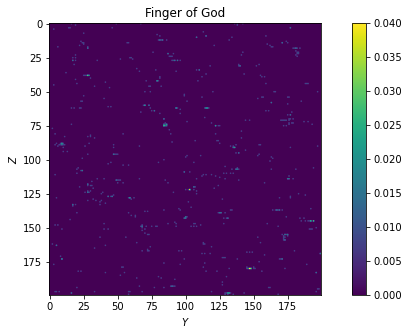

In [14]:
plt.figure(figsize = (14,5))
im = plt.imshow(denFG_arr[0,:,:]) #X=0
plt.colorbar(im,fraction = 0.046, pad = 0.04)
plt.title(r'Finger of God')
plt.xlabel(r'$Y$')
plt.ylabel(r'$Z$')
plt.show()